# 🌴 Setup and Installation

In [39]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Weights and Biases related imports
import wandb
from wandb.keras import WandbMetricsLogger
from wandb.keras import WandbModelCheckpoint
from wandb.keras import WandbEvalCallback

# 🌳 Hyperparameters

Use of proper config system is a recommended best practice for reproducible machine learning. We can track the hyperparameters for every experiment using W&B. In this colab we will be using simple Python `dict` as our config system.

In [40]:
configs = dict(
    num_classes = 10,
    shuffle_buffer = 1024,
    batch_size = 128,
    image_size = 28,
    image_channels = 1,
    earlystopping_patience = 3,
    learning_rate = 1e-3,
    epochs = 20,
    model_name = "resnet-18"
)

# 🍁 Dataset

In this colab, we will be using [FashionMNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset from TensorFlow Dataset catalog. We aim to build a simple image classification pipeline using TensorFlow/Keras.

In [41]:
train_ds, valid_ds = tfds.load('fashion_mnist', split=['train', 'test'])

### Augmentations

In [42]:
import keras_cv as kcv
from keras_cv.layers import MixUp
from keras_cv.models.resnet_v1 import ResNet18

In [43]:
mix_up = MixUp(alpha=0.4)

def apply_mixup(samples: dict) -> dict:
    samples = mix_up(samples, training=True)
    return samples

In [44]:
AUTOTUNE = tf.data.AUTOTUNE


def parse_data(example):
    # Get image
    image = example["image"]
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # Get label
    label = example["label"]
    label = tf.one_hot(label, depth=configs["num_classes"])

    return image, label


def to_dict(images, labels):
    "Apply this after batching"
    return {"images": images, "labels": labels}


def to_tuple(samples_dict):
    "Apply after augmentation is done"
    return samples_dict["images"], samples_dict["labels"]


def get_dataloader(
    ds,
    configs,
    dataloader_type="train",
    augmentation=True
):
    dataloader = ds.map(parse_data, num_parallel_calls=AUTOTUNE)

    if dataloader_type=="train":
        dataloader = dataloader.shuffle(configs["shuffle_buffer"])

    dataloader = (
        dataloader
        .batch(configs["batch_size"])
    )
    
    if augmentation and dataloader_type=="train":
        dataloader = (
            dataloader
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .map(apply_mixup, num_parallel_calls=AUTOTUNE)
            .map(to_tuple, num_parallel_calls=AUTOTUNE)
        )

    dataloader = dataloader.prefetch(AUTOTUNE)

    return dataloader

In [45]:
trainloader = get_dataloader(train_ds, configs)
validloader = get_dataloader(valid_ds, configs, dataloader_type="valid")

In [46]:
next(iter(trainloader))

2022-12-22 16:22:28.972323: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(128, 28, 28, 1), dtype=float32, numpy=
 array([[[[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         ...,
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
    

# 🎄 Model

In [56]:
# def get_model(configs):
#     backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(weights=None, include_top=False)
#     backbone.trainable = False

#     inputs = layers.Input(shape=(configs["image_size"], configs["image_size"], configs["image_channels"]))
#     resize = layers.Resizing(32, 32)(inputs)
#     neck = layers.Conv2D(3, (3,3), padding="same")(resize)
# #     preprocess_input = tf.keras.applications.mobilenet.preprocess_input(neck)
# #     x = backbone(preprocess_input)
#     x = backbone(neck)
#     x = layers.GlobalAveragePooling2D()(x)
#     outputs = layers.Dense(configs["num_classes"], activation="softmax")(x)

#     return models.Model(inputs=inputs, outputs=outputs)

# def get_model(input_shape, num_classes):
#     inputs = tf.keras.Input(shape=input_shape)

#     # Entry block
# #     x = layers.Rescaling(1.0 / 255)(inputs)
#     x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     for size in [64, 128, 256, 512]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     x = layers.SeparableConv2D(1024, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         activation = "sigmoid"
#         units = 1
#     else:
#         activation = "softmax"
#         units = num_classes

#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(units, activation=activation)(x)
#     return tf.keras.Model(inputs, outputs)

def get_model(configs):
    backbone = ResNet18(include_rescaling=False, include_top=False, weights=None, input_shape=(None, None, 1))
    backbone.trainable = True

    inputs = layers.Input(shape=(configs["image_size"], configs["image_size"], configs["image_channels"]))
#     resize = layers.Resizing(32, 32)(inputs)
#     neck = layers.Conv2D(3, (3,3), padding="same")(resize)
#     preprocess_input = tf.keras.applications.mobilenet.preprocess_input(neck)
#     x = backbone(preprocess_input)
    x = backbone(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(configs["num_classes"], activation="softmax")(x)

    return models.Model(inputs=inputs, outputs=outputs)

In [57]:
tf.keras.backend.clear_session()
model = get_model(configs)
# model = get_model(
#     input_shape=(configs["image_size"], configs["image_size"], configs["image_channels"]),
#     num_classes=configs["num_classes"]
# )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 resnet18 (Functional)       (None, None, None, 512)   11179840  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 11,184,970
Trainable params: 11,175,370
Non-trainable params: 9,600
_________________________________________________________________


# ☘️ Callbacks

## Builtin callbacks

In [58]:
CALLBACKS = []

In [59]:
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=configs['earlystopping_patience'],
    restore_best_weights=True
)
CALLBACKS += [earlystopper]

In [60]:
class WandbClfEvalCallback(WandbEvalCallback):
    def __init__(
        self, validloader, data_table_columns, pred_table_columns, num_samples=100
    ):
        super().__init__(data_table_columns, pred_table_columns)

        self.val_data = validloader.unbatch()

    def add_ground_truth(self, logs=None):
        for idx, (image, label) in enumerate(self.val_data):
            self.data_table.add_data(
                idx,
                wandb.Image(image),
                np.argmax(label, axis=-1)
            )

    def add_model_predictions(self, epoch, logs=None):
        # Get predictions
        preds = self._inference()
        table_idxs = self.data_table_ref.get_index()

        for idx in table_idxs:
            pred = preds[idx]
            self.pred_table.add_data(
                epoch,
                self.data_table_ref.data[idx][0],
                self.data_table_ref.data[idx][1],
                self.data_table_ref.data[idx][2],
                pred
            )

    def _inference(self):
      preds = []
      for image, label in self.val_data:
          pred = self.model(tf.expand_dims(image, axis=0))
          argmax_pred = tf.argmax(pred, axis=-1).numpy()[0]
          preds.append(argmax_pred)
          
      return preds

In [65]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.01, decay_steps=500
)

In [70]:
steps = len(trainloader)*configs["epochs"]

lrs = []

for i in range(steps):
    lrs.append(lr_scheduler(i).numpy())

In [73]:
lrs[-1]

0.0

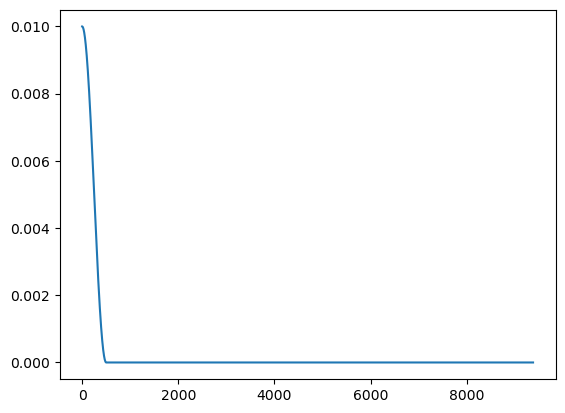

In [72]:
plt.plot(lrs)

# 🌿 Compile Model

In [61]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
)

# 🌻 Train

In [62]:
# Initialize a W&B run
run = wandb.init(
    entity="fastai",
    project="fashion_mnist",
    group="tf",
    config = configs
)

# Train your model
model.fit(
    trainloader,
    epochs = configs["epochs"],
    validation_data = validloader,
    callbacks = [
        WandbMetricsLogger(log_freq=2),
#         WandbModelCheckpoint(filepath="models/"),
#         WandbClfEvalCallback(
#             validloader,
#             data_table_columns=["idx", "image", "ground_truth"],
#             pred_table_columns=["epoch", "idx", "image", "ground_truth", "prediction"]
#         )
    ]
)

Epoch 1/20
469/469 [==============================] - 17s 17ms/step - loss: 1.0958 - accuracy: 0.7376 - val_loss: 0.8410 - val_accuracy: 0.7093
Epoch 2/20
469/469 [==============================] - 7s 16ms/step - loss: 0.9144 - accuracy: 0.7808 - val_loss: 0.3715 - val_accuracy: 0.8805
Epoch 3/20
469/469 [==============================] - 7s 16ms/step - loss: 0.8718 - accuracy: 0.7930 - val_loss: 0.4733 - val_accuracy: 0.8584
Epoch 4/20
469/469 [==============================] - 7s 16ms/step - loss: 0.8447 - accuracy: 0.8054 - val_loss: 0.3465 - val_accuracy: 0.8890
Epoch 5/20
469/469 [==============================] - 7s 16ms/step - loss: 0.8256 - accuracy: 0.8115 - val_loss: 0.3468 - val_accuracy: 0.8897
Epoch 6/20
469/469 [==============================] - 8s 17ms/step - loss: 0.8096 - accuracy: 0.8172 - val_loss: 0.3450 - val_accuracy: 0.8885
Epoch 7/20
469/469 [==============================] - 7s 16ms/step - loss: 0.8031 - accuracy: 0.8193 - val_loss: 0.3441 - val_accuracy: 0.894

In [63]:
loss, acc = model.evaluate(validloader)
wandb.log({"Eval Acc": acc, "Eval Loss": loss})

79/79 [==============================] - 0s 6ms/step - loss: 0.2675 - accuracy: 0.9105


In [64]:
# Close the W&B run
run.finish()

Eval Acc,▁
Eval Loss,▁
batch/accuracy,▁▂▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▅▅▆▆▆▆▇▆▇▇▇▇▇████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▇▆▇▇▇▇██▇▇██▆█▇▇▅██
